#**PredictRisk: A Machine Learning Approach to Maternal Health Risk Classification**

## **Aim** : **Predicting Pregnancy Risk Levels**

## Context

Maternal health remains a critical public health priority, particularly in low- and middle-income countries where complications during pregnancy account for a significant number of preventable deaths. Early identification of women at risk can help healthcare providers intervene timely and reduce adverse maternal outcomes. Leveraging data and predictive analytics can significantly improve risk stratification in pregnant women.



## Background

Pregnancy is a delicate physiological process influenced by numerous health indicators including blood pressure, blood sugar levels, heart rate, age, and body temperature. Identifying potential risks early can assist in reducing maternal mortality and improving prenatal care. Traditional clinical decision-making can be augmented with machine learning (ML) models to classify maternal risk levels with higher accuracy and speed.

This project leverages a real-world dataset to build and evaluate classification models that predict whether a pregnant woman falls into a **low**, **mid**, or **high** risk category based on health parameters.



##  Problem Statement

> Can we develop a predictive model using physiological data to accurately classify maternal health risk levels into low, mid, or high risk categories?

The goal is to assist healthcare professionals by providing a data-driven risk assessment tool that improves the early detection of maternal health complications.



##  Data Dictionary

| Feature        | Description                                                               |
|----------------|---------------------------------------------------------------------------|
| `Age`          | Age of the pregnant woman (in years)                                       |
| `SystolicBP`   | Systolic Blood Pressure (mm Hg)                                            |
| `DiastolicBP`  | Diastolic Blood Pressure (mm Hg)                                           |
| `BS`           | Blood Sugar Level (measured in mmol/L)                                     |
| `BodyTemp`     | Body Temperature (in degrees Celsius)                                      |
| `HeartRate`    | Pulse rate or heart rate (beats per minute)                                |
| `RiskLevel`    | Target variable - Categorized as `low risk`, `mid risk`, or `high risk`    |



#1. Importing the dependencies

In [1]:
import warnings
warnings.simplefilter(action ="ignore")
warnings.filterwarnings("ignore")

from collections import Counter

# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

# Data directory
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Importing The Data Of Maternal Health Risk**

## 2. Data Loading and Understanding

In [2]:
m_df = pd.read_csv("/content/Maternal Health Risk Data Set.csv")
m_df.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,35,120,60,6.10,98.0,76,low risk
5,23,140,80,7.01,98.0,70,high risk
6,23,130,70,7.01,98.0,78,mid risk
7,35,85,60,11.00,102.0,86,high risk
8,32,120,90,6.90,98.0,70,mid risk
9,42,130,80,18.00,98.0,70,high risk


In [3]:
print(f"The dataset size: {m_df.shape}")

The dataset size: (1014, 7)


In [4]:
m_df.tail(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1004,13,90,65,9.0,101.0,80,high risk
1005,17,90,65,7.7,103.0,67,high risk
1006,17,85,60,6.3,102.0,86,high risk
1007,40,120,75,7.7,98.0,70,high risk
1008,48,120,80,11.0,98.0,88,high risk
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


In [5]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
m_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


In [7]:
print(m_df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


##  Data Overview
- **Total Records**: 1024
- **Number of Features**: 6 predictor variables + 1 target (`RiskLevel`)
- **Target Classes**:
  - Low risk: 406
  - Mid risk: 336
  - High risk: 282

**Insight**: Class imbalance is moderate and should be handled during modeling using techniques like stratified sampling or class weighting.



#3. Exploratory Data Analysis (EDA)

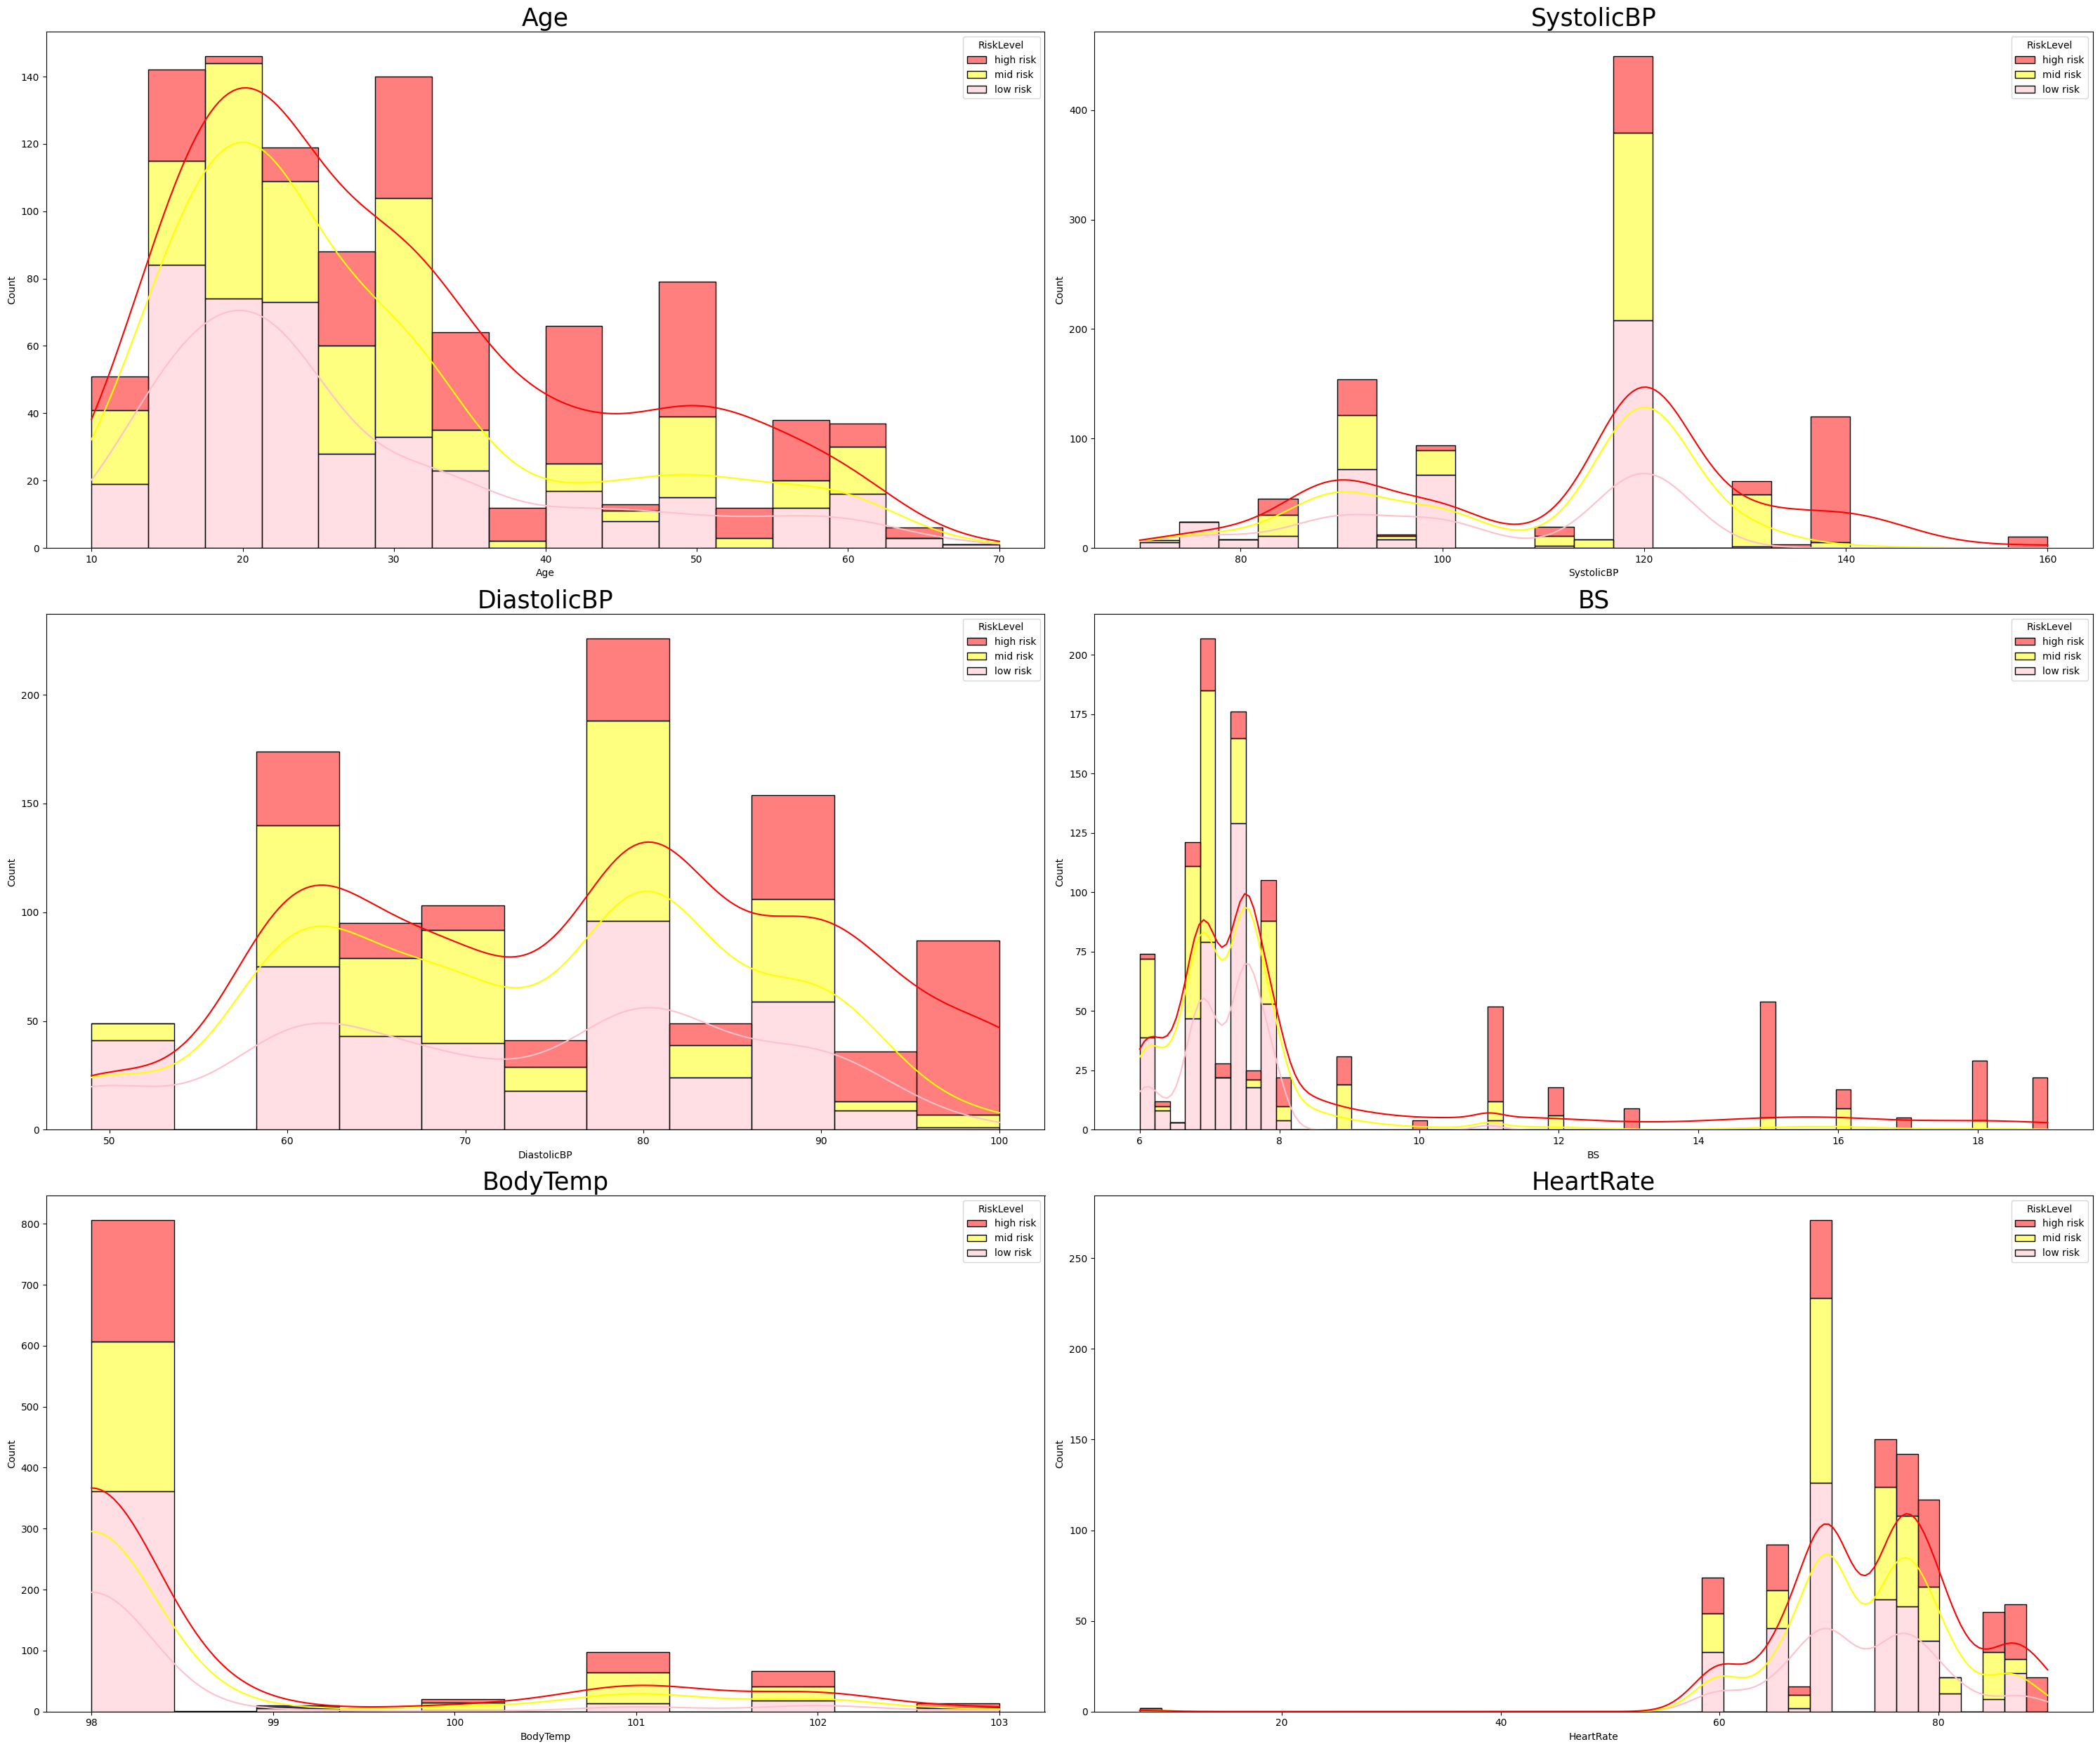

In [8]:
# Ploting stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 25))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), m_df.columns):
    sns.histplot(data=m_df,
                 x=column,
                 kde=True,
                 hue="RiskLevel",
                 hue_order=risk_level_order,
                 multiple="stack",
                 palette={"low risk": "pink", "mid risk": "yellow", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=25)

plt.tight_layout()
plt.savefig("maternal_features_description.png")
plt.show()

##  Feature Distributions by Risk Level
Stacked histograms were plotted for all features categorized by `RiskLevel`.

### Observations:
- **Age**: Higher age is associated with higher risk. Younger individuals are generally low risk.
- **SystolicBP & DiastolicBP**:
  - Both increase with risk.
  - Higher blood pressure values are strongly linked with high risk.
- **BS (Blood Sugar)**:
  - Values above 10 are mostly mid or high risk.
  - Indicates gestational diabetes could be a factor.
- **Body Temperature**:
  - Higher body temperatures appear more in high risk, but overall separation is not strong.
- **Heart Rate**:
  - Extreme heart rate values correspond to higher risk categories.

## Outlier Detection

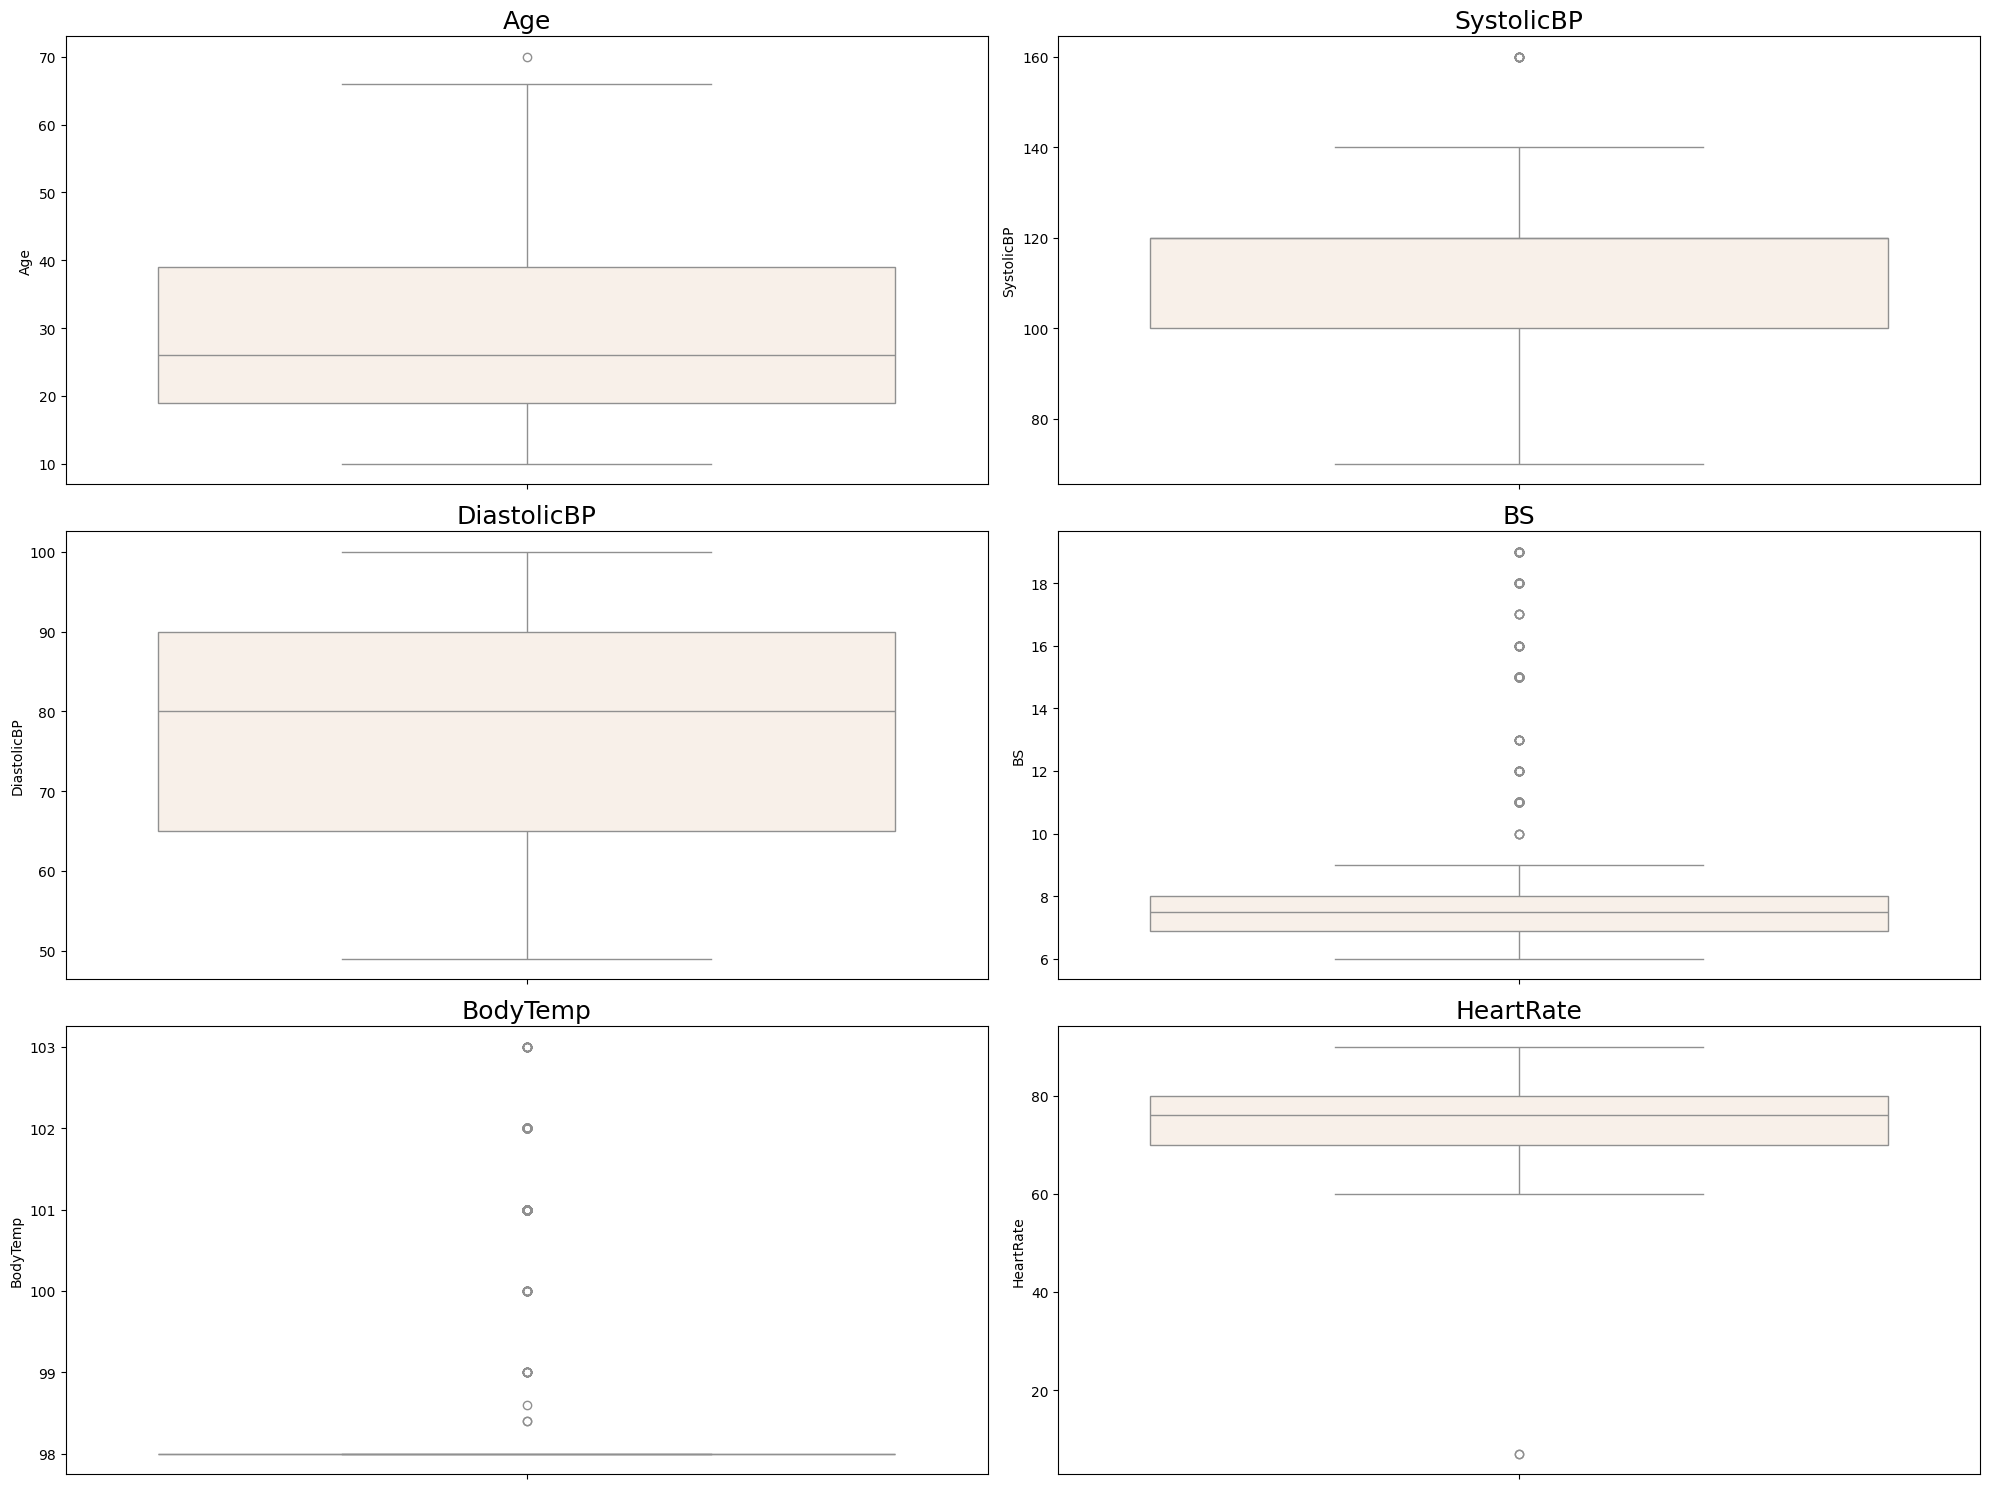

In [9]:
# Ploting boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), m_df.columns):
    sns.boxplot(y=m_df[column],
                color="#FAF0E6",
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

## Outlier Detection (Boxplots)

### Findings:
- **Heart Rate**: A clear outlier (value = 7) was identified and removed.
- Other features show mild skewness but no severe outliers.

**Insight**: Cleaning extreme values helps improve model training and reduces error sensitivity.

## Correlation Analysis of Variables

###  Maping RiskLevel to integer values

In [10]:
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
m_df["RiskLevel"] = m_df["RiskLevel"].map(risk_mapping)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


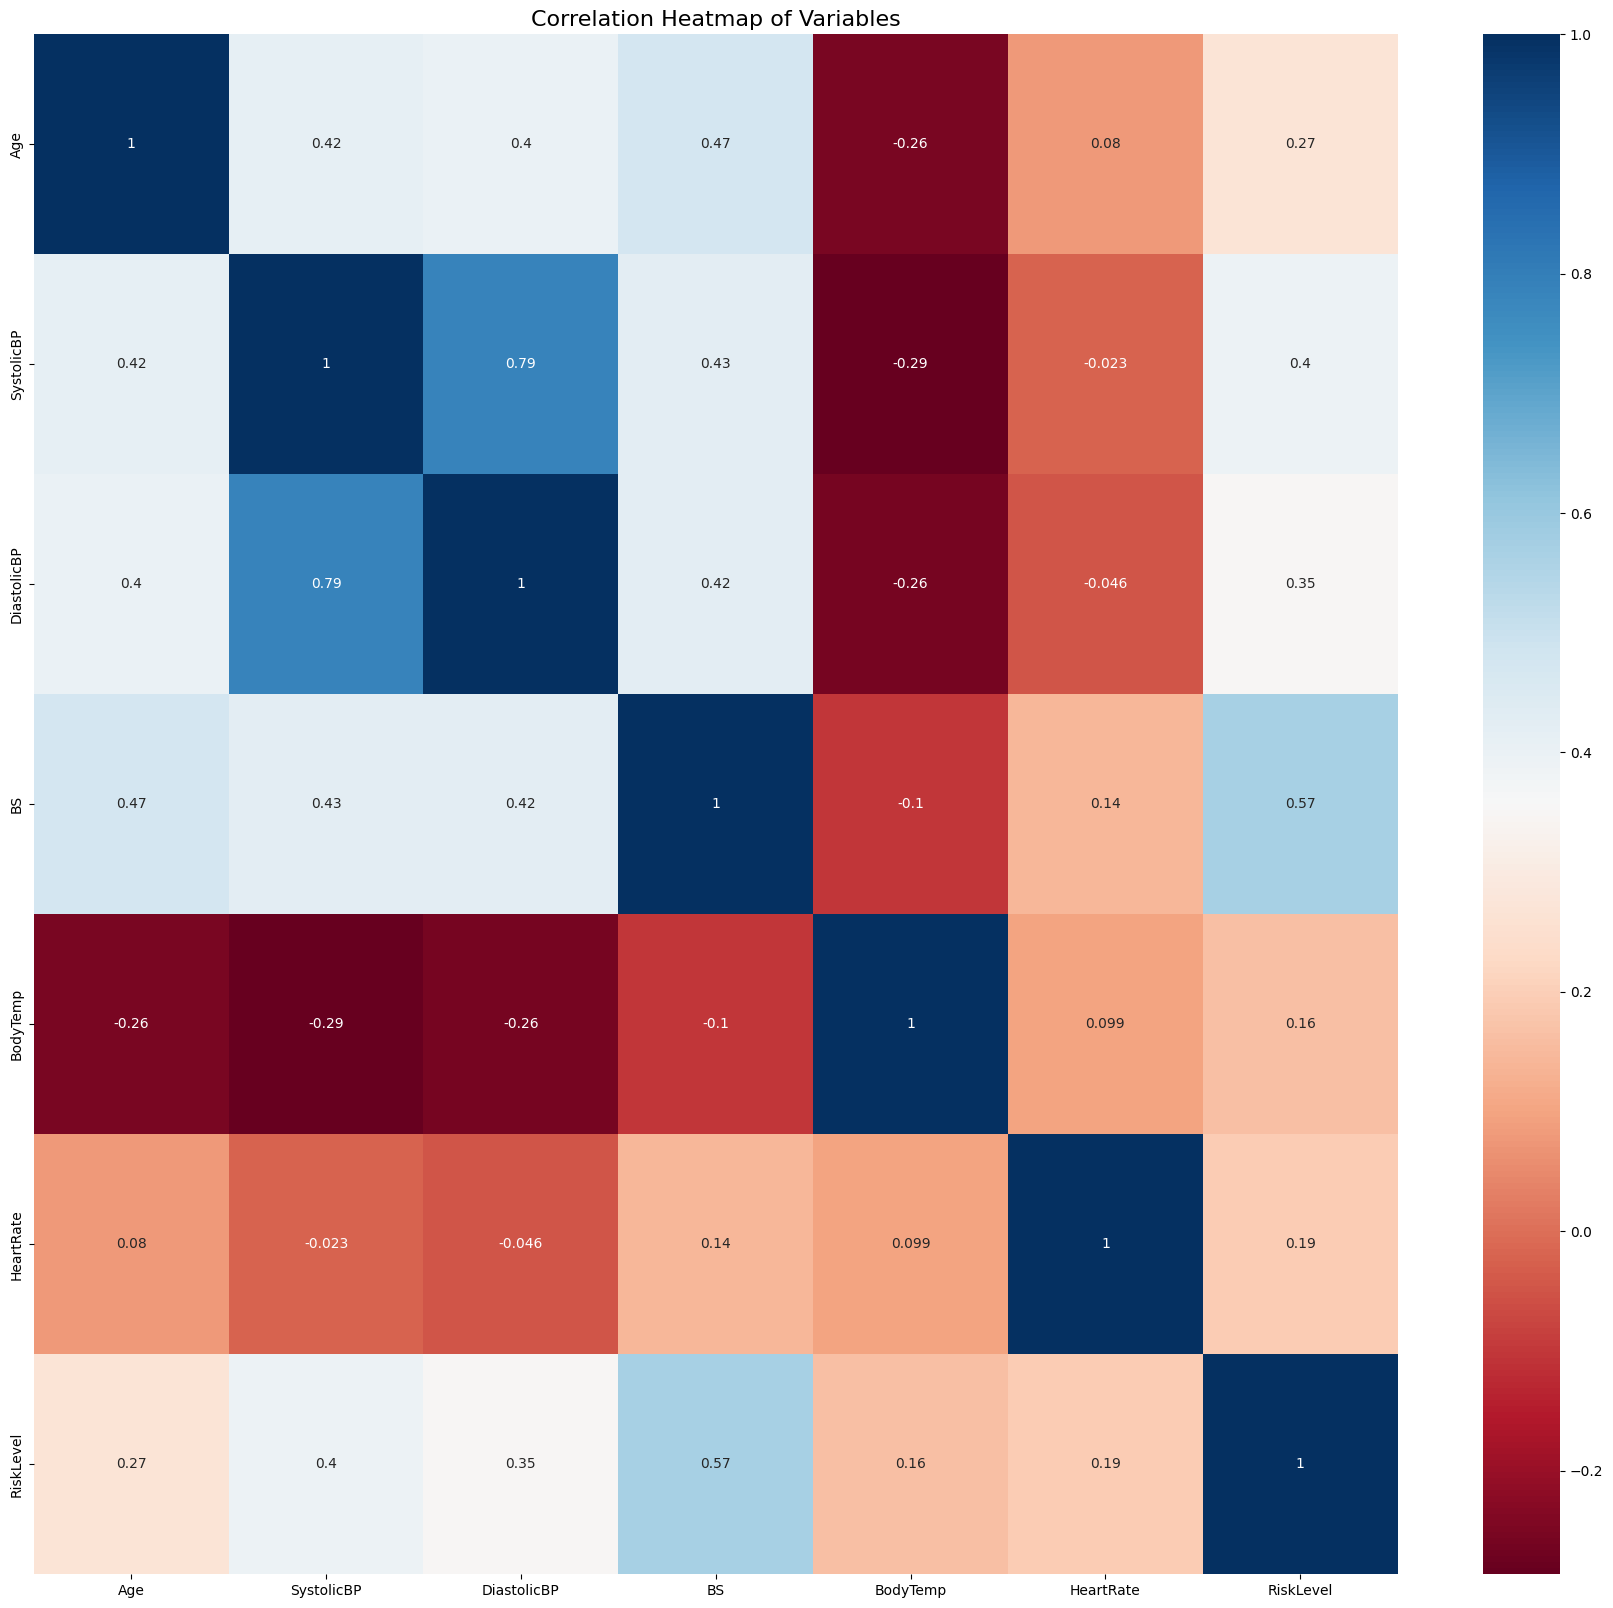

In [11]:
# Creating a correlation heatmap
plt.figure(figsize=(22,20))
sns.heatmap(m_df.corr(), annot=True, cmap = "RdBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

##  Correlation Analysis

### Heatmap Insights:
- **SystolicBP ↔ DiastolicBP** correlation = 0.79
  - Indicates high multicollinearity.
  - **Action Taken**: Dropped `SystolicBP` to eliminate redundancy.

**Insight**: Removing highly correlated variables improves model generalization and reduces overfitting risk.



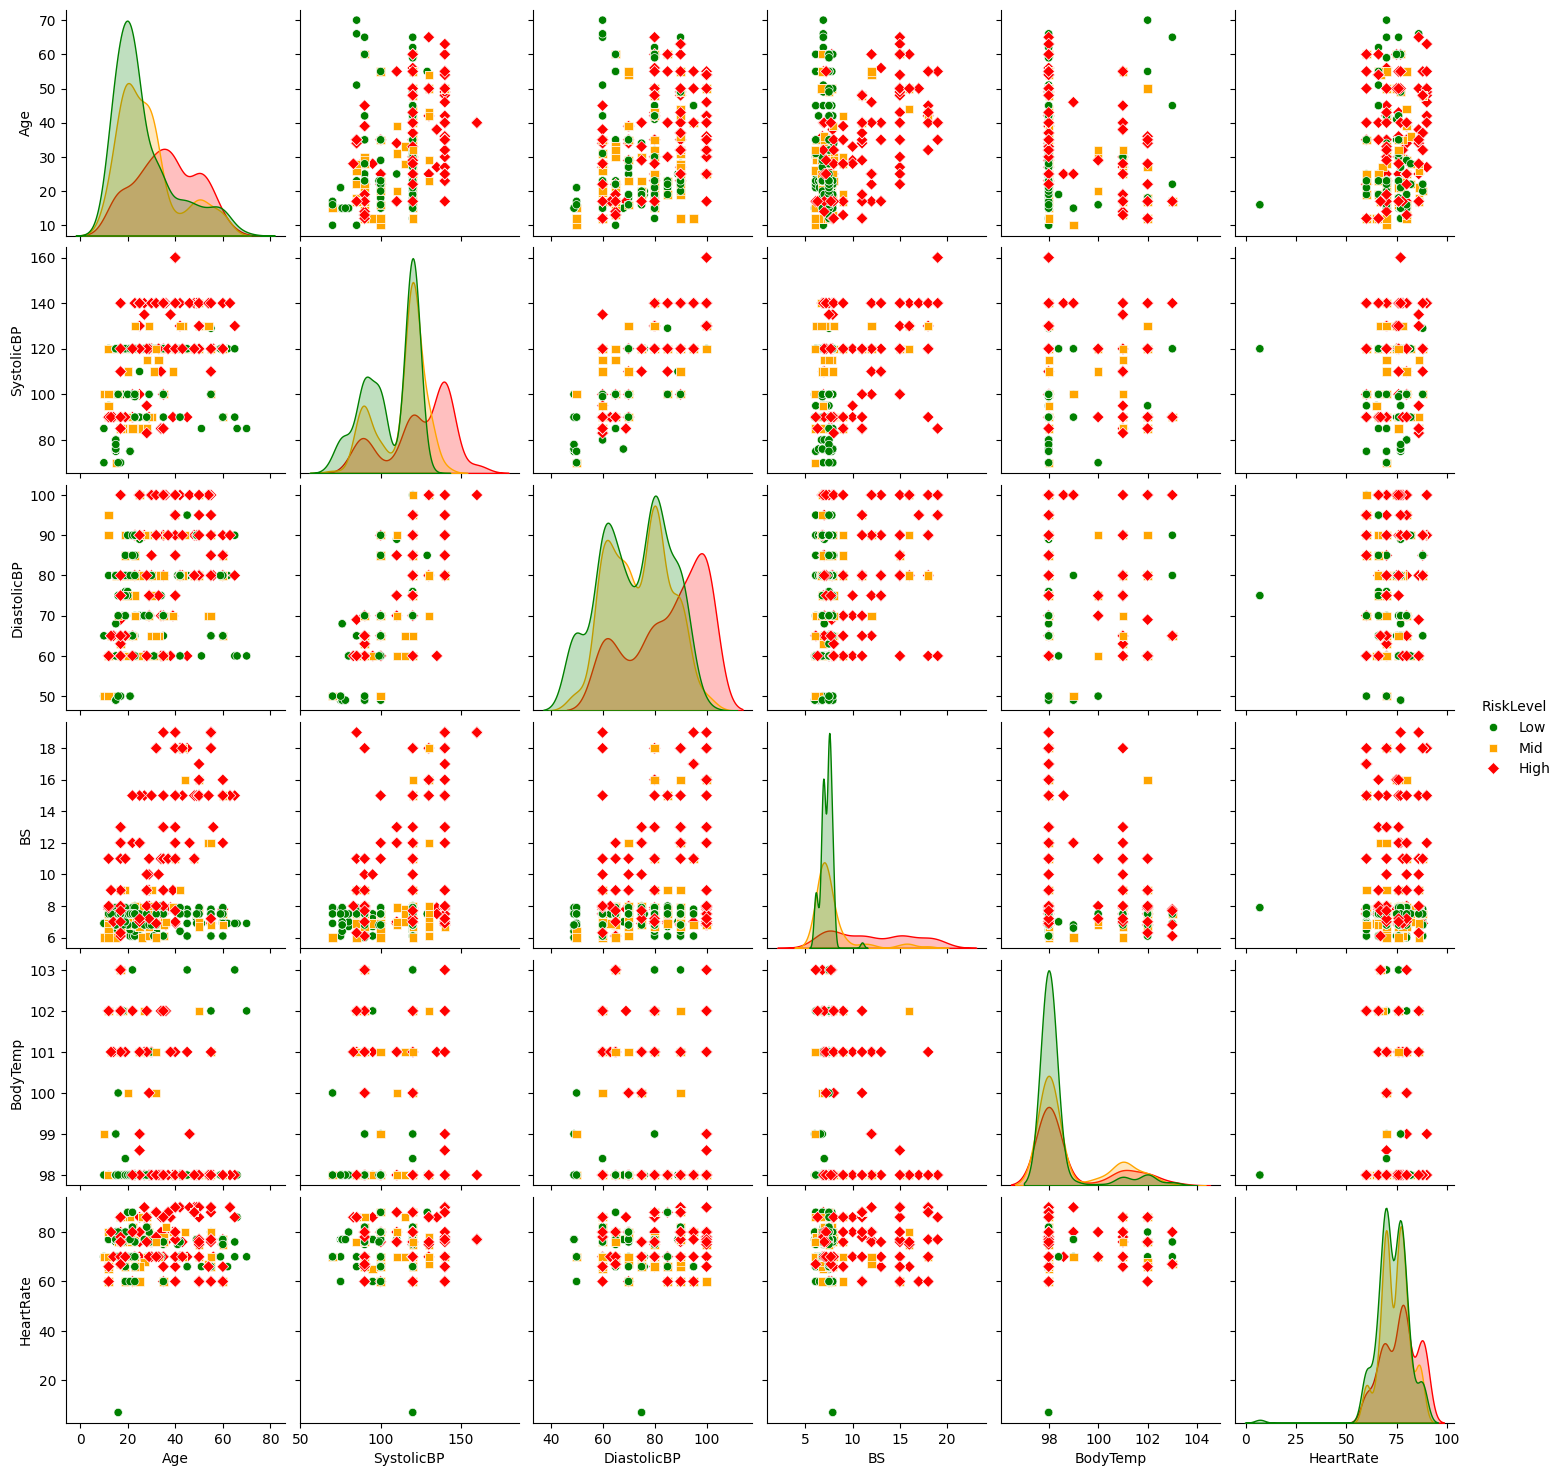

In [12]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(m_df, hue='RiskLevel',
                    palette=risk_colors,
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)
plt.savefig("maternal_pairplot_to_see_patterns.png")
plt.show()

##  Pairplot Visualization

### Class Separation:
- **Low Risk**: Clusters in low ranges for most features.
- **High Risk**: Clusters with high BP, BS, and Age.
- **Mid Risk**: Overlaps with both low and high risk categories.

**Insight**: While patterns exist for low and high risk, mid risk is harder to separate, which might challenge classifier accuracy.



In [13]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = m_df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [14]:
# Drop SystolicBP for model training
m_df = m_df.drop(["SystolicBP"], axis=1)

## Variance Inflation Factor (VIF)
- Calculated VIF for BP variables:
  - High VIF confirmed multicollinearity.
  - **SystolicBP was removed**.


## Outlier Treatment

In [15]:
# Identify the outlier in HeartRate
m_df.HeartRate.sort_values().head()

,HeartRate
499,7
908,7
1000,60
1010,60
705,60


In [16]:
# Remove the outlier in HeartRate
m_df = m_df.drop(m_df.index[m_df.HeartRate == 7])

##  Outlier Treatment
- Removed a single extreme value (HeartRate = 7).
- No other extreme outliers present.
- Standardized the features afterward.

In [17]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


# Model Building

In [18]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(m_df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = m_df["RiskLevel"]

In [19]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


In [20]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

## Logistic Regression

In [21]:

# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.64


In [22]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.6037037  0.5962963  0.57992565]
CrossValMeans: 0.593
CrossValStandard Deviation: 0.01


In [23]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [24]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(),
                                param_grid=params_LR,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True,
                                )

In [25]:
GridSearchCV_LR.fit(X_train, y_train);

In [26]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.602


In [27]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [28]:
print(f"Mean Square Error for Logistic Regression = {round(mse_logistic_regression, 3)}")
print(f"Root Mean Square Error for Logistic Regression = {round(rmse_logistic_regression, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_logistic_regression_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_logistic_regression_test, 3)}")

Mean Square Error for Logistic Regression = 0.512
Root Mean Square Error for Logistic Regression = 0.716
R^2(coefficient of determination) on training set = 0.609
R^2(coefficient of determination) on testing set = 0.635


In [29]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

Confusion Matrix:
[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


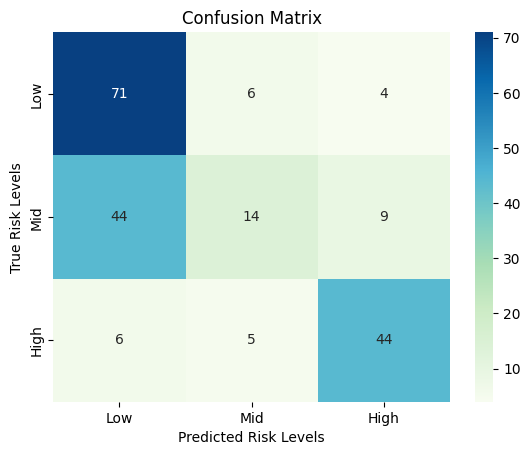

In [30]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

#K-Nearest Neighbors

In [31]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.665


In [32]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.61481481 0.68148148 0.62453532]
CrossValMeans: 0.64
CrossValStandard Deviation: 0.029


In [33]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [34]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [35]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train);

In [36]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best parameter values:
{'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.795


In [37]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [38]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.251
Root Mean Square Error for K_Nearest Neighbor = 0.501
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [39]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


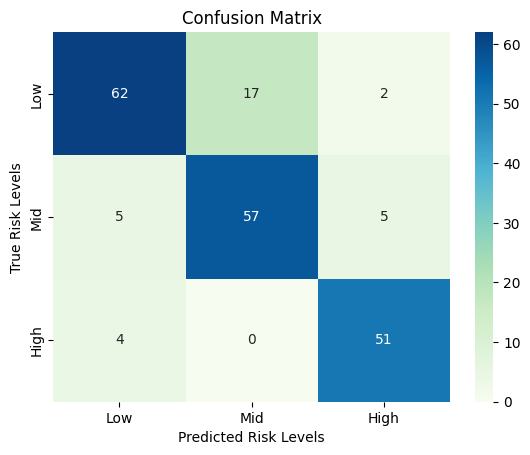

In [40]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

In [41]:
# Baseline model of Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest_mod = random_forest.fit(X_train, y_train)
print(f"Baseline Random Forest: {round(random_forest_mod.score(X_test, y_test), 3)}")
pred_random_forest = random_forest_mod.predict(X_test)

Baseline Random Forest: 0.837


In [42]:
# Cross validate Random Forest Classifier model
scores_RF = cross_val_score(random_forest, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Random forest model:\n{scores_RF}")
print(f"CrossValMeans: {round(scores_RF.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_RF.std(), 3)}")

Scores(Cross validate) for Random forest model:
[0.81111111 0.8037037  0.82899628]
CrossValMeans: 0.815
CrossValStandard Deviation: 0.011


In [43]:
params_RF = {"min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators" :[50,100,200,300,400],
              "max_depth": [None, 10, 20, 30],
              "criterion": ["gini", "entropy"]
              }

In [44]:
GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(),
                                param_grid=params_RF,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [45]:
GridSearchCV_RF.fit(X_train, y_train);

In [46]:
print(f"Best estimator for RF model:\n{GridSearchCV_RF.best_estimator_}")
print(f"Best parameter values for RF model:\n{GridSearchCV_RF.best_params_}")
print(f"Best score for RF model: {round(GridSearchCV_RF.best_score_, 3)}")

Best estimator for RF model:
RandomForestClassifier(max_depth=20, n_estimators=50)
Best parameter values for RF model:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score for RF model: 0.821


In [47]:
# Testing with new parameter
random_forest = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
random_forest_mod = random_forest.fit(X_train, y_train)
pred_random_forest = random_forest_mod.predict(X_test)

mse_random_forest = mean_squared_error(y_test, pred_random_forest)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, pred_random_forest))
score_random_forest_train = random_forest_mod.score(X_train, y_train)
score_random_forest_test = random_forest_mod.score(X_test, y_test)

In [48]:
print(f"Mean Square Error for Random Forest = {round(mse_random_forest, 3)}")
print(f"Root Mean Square Error for Random Forest = {round(rmse_random_forest, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_random_forest_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_random_forest_test, 3)}")

Mean Square Error for Random Forest = 0.236
Root Mean Square Error for Random Forest = 0.486
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [49]:
print("Classification Report")
print(classification_report(y_test, pred_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_random_forest))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        81
           1       0.79      0.79      0.79        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[64 14  3]
 [ 9 53  5]
 [ 2  0 53]]


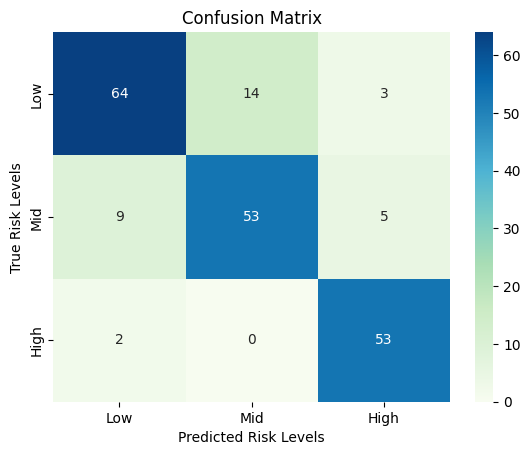

In [50]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_random_forest), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

# Gradient Boosting Classifier

In [63]:
# Baseline model of gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc_mod = gbc.fit(X_train, y_train)
print(f"Baseline gradient boosting classifier: {round(gbc_mod.score(X_test, y_test), 3)}")
pred_gbc = gbc_mod.predict(X_test)

Baseline gradient boosting classifier: 0.783


In [65]:
# Cross validate Gradient Boosting Classifier model
scores_GBC = cross_val_score(gbc, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Gradient Boosting Classifier model:\n{scores_GBC}")
print(f"CrossValMeans: {round(scores_GBC.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_GBC.std(), 3)}")

Scores(Cross validate) for Gradient Boosting Classifier model:
[0.74814815 0.78518519 0.80297398]
CrossValMeans: 0.779
CrossValStandard Deviation: 0.023


In [77]:
# Hyperparameter tuning with GridSearchCV
params_GBC = {
    "loss": ["log_loss"],  # <- 'deviance' and 'exponential' are not valid for multiclass
    "learning_rate": [0.01, 0.05, 0.075, 0.1],
    "n_estimators": [100, 250, 500],
    "max_depth": [3, 5, 8, 10],
    "subsample": [0.8, 1]
}

In [78]:
GridSearchCV_GBC = GridSearchCV(estimator=GradientBoostingClassifier(),
                                param_grid=params_GBC,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [79]:
GridSearchCV_GBC = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params_GBC,
    cv=3,
    scoring="accuracy",
    return_train_score=True,
    error_score='raise'  # <- Raise errors instead of assigning NaN
)

In [80]:
# Fit model with train data
GridSearchCV_GBC.fit(X_train, y_train);

In [81]:
print(f"Best estimator values for GBC model:\n{GridSearchCV_GBC.best_estimator_}")
print(f"Best parameter values for GBC model:\n{GridSearchCV_GBC.best_params_}")
print(f"Best score value foe GBC model: {round(GridSearchCV_GBC.best_score_, 3)}")

Best estimator values for GBC model:
GradientBoostingClassifier(learning_rate=0.01, max_depth=8, n_estimators=250,
                           subsample=0.8)
Best parameter values for GBC model:
{'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best score value foe GBC model: 0.818


In [86]:
# Test with new parameter
gbc = GradientBoostingClassifier(
    learning_rate=0.5,
    loss="log_loss",
    max_depth=10,
    n_estimators=100,
    subsample=1,
    random_state=42
)

gbc_mod = gbc.fit(X_train, y_train)
pred_gbc = gbc_mod.predict(X_test)

# Evaluation
mse_gbc = mean_squared_error(y_test, pred_gbc)
rmse_gbc = np.sqrt(mse_gbc)
score_gbc_train = gbc_mod.score(X_train, y_train)
score_gbc_test = gbc_mod.score(X_test, y_test)

In [87]:
print(f"Mean Square Error for Gradient Boosting Classifier = {round(mse_gbc, 3)}")
print(f"Root Mean Square Error for Gradient Boosting Classifier = {round(rmse_gbc, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_gbc_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_gbc_test, 3)}")

Mean Square Error for Gradient Boosting Classifier = 0.232
Root Mean Square Error for Gradient Boosting Classifier = 0.481
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.842


### Classification Report

In [88]:
print("Classification Report")
print(classification_report(y_test, pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_gbc))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        81
           1       0.80      0.79      0.80        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.85       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[65 13  3]
 [ 9 53  5]
 [ 2  0 53]]


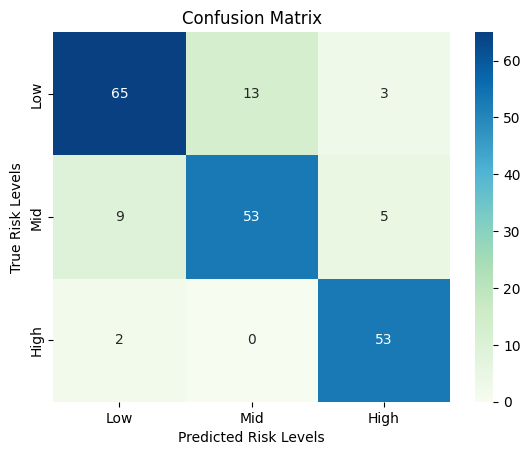

In [89]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_gbc), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

####  Create a DataFrame to store model evaluation results

In [90]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest", "Gradient Boosting Classifier"],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(logistic_regression_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(random_forest_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(gbc_mod, X_train, y_train, cv=3).mean(),
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        logistic_regression_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        random_forest_mod.score(X_test, y_test),
        gbc_mod.score(X_test, y_test),
    ]
})
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [logistic_regression_mod, knn_mod, random_forest_mod, gbc_mod]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df

,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.842365,Gradient Boosting Classifier,0.819547,0.841706,0.842365,0.841021
0.837438,K-Nearest Neighbors,0.794818,0.840899,0.837438,0.836922
0.837438,Random Forest,0.810891,0.836980,0.837438,0.836060
0.635468,Logistic Regression,0.601960,0.628104,0.635468,0.593824


# Model Evaluation Summary
- In the evaluation of model performance, the Gradient Boosting Classifier emerges as the top-performing model across all key metrics. It achieves a test accuracy of 84.24%, which is higher than both the K-Nearest Neighbors and Random Forest models, each recording a test accuracy of 83.74%. Notably, the Gradient Boosting Classifier also maintains a balanced precision (84.17%), recall (84.24%), and F1 score (84.10%), indicating consistent performance across all aspects of classification quality.

- Importantly, its train score (81.95%) is slightly lower than the test score, suggesting good generalization without signs of overfitting — a key indicator of a reliable and robust model.

- The K-Nearest Neighbors model follows closely behind, with strong precision (84.09%) and a solid F1 score (83.69%), though its train score (79.48%) is slightly lower, hinting at underfitting in more complex patterns. The Random Forest model shows competitive results, but its slightly lower precision (83.70%) and F1 score (83.61%) make it slightly less effective compared to KNN and GBC.

- In contrast, Logistic Regression underperforms across all metrics, with a test accuracy of just 63.55% and the lowest F1 score (59.38%), demonstrating limited capability to handle the complexity of the dataset.

##  Insights

- **Clear Feature Patterns**: Age, BP, BS, and Heart Rate are key indicators for predicting maternal risk.
- **Class Overlap**: The `mid risk` class overlaps significantly with others, making it harder to separate.
- **Good Model Fit**: Gradient Boosting showed the highest test accuracy (84.24%) with balanced precision and recall.
- **Low Model Performance**: Logistic Regression struggled with this multiclass problem, indicating the need for non-linear models.



##  Conclusion

- Machine learning can reliably predict maternal health risks using basic physiological data.
- Among all models tested, **Gradient Boosting Classifier** performed the best in balancing bias-variance tradeoff.
- The feature distribution and correlation analysis helped guide preprocessing decisions, such as outlier removal and multicollinearity handling.

##  Recommendations

1. **Deploy Gradient Boosting Model** in clinical decision systems as a preliminary risk classifier.
2. **Integrate with EHR systems** to allow automatic risk computation during patient checkups.
3. **Collect more data** to reduce class imbalance and improve model generalization.
4. **Explore domain-specific features**, such as previous pregnancy history or BMI, for better predictive power.
5. **Address class overlap** by experimenting with ensemble models, cost-sensitive learning, or more advanced sampling techniques.


## Saving and loading the trained maternal health risk model

###  Saving the model

In [92]:
import pickle

# Save the trained Gradient Boosting model
pickle.dump(gbc_mod, open('finalized_maternal_model.sav', 'wb'))


### Loading the model

In [96]:
from google.colab import files

# This will prompt you to upload the file
uploaded = files.upload()


Saving finalized_maternal_model.sav to finalized_maternal_model (1).sav


In [97]:
import pickle

# Load the uploaded model
maternal_model = pickle.load(open('finalized_maternal_model.sav', 'rb'))


In [118]:
maternal_model.predict([[40, 110, 15.2, 101.5, 130]])

array([2])